In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df1 = pd.read_csv("Class1.txt",delimiter=' ', header=None)
df2 = pd.read_csv("Class2.txt",delimiter=' ', header=None)
df3 = pd.read_csv("Class3.txt",delimiter=' ', header=None)

In [ ]:
df1 = df1.sample(frac=1, random_state=42).reset_index(drop=True)
df2 = df2.sample(frac=1, random_state=42).reset_index(drop=True)
df3 = df3.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
df1_train = df1[:int(len(df1)*0.7)]
df1_test = df1[int(len(df1)*0.7):]
df2_train = df2[:int(len(df2)*0.7)]
df2_test = df2[int(len(df2)*0.7):]
df3_train = df3[:int(len(df3)*0.7)]
df3_test = df3[int(len(df3)*0.7):]
print(len(df1_train))
print(len(df1_test))

350
150


## Bayes classifier using KNN density estimation

Classification Report for k=1:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       150
     Class 1       1.00      1.00      1.00       150
     Class 2       1.00      1.00      1.00       150

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450

Classification Report for k=3:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       150
     Class 1       1.00      1.00      1.00       150
     Class 2       1.00      1.00      1.00       150

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450

Classification Report for k=5:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       150
     Class 1       1.00      1.00   

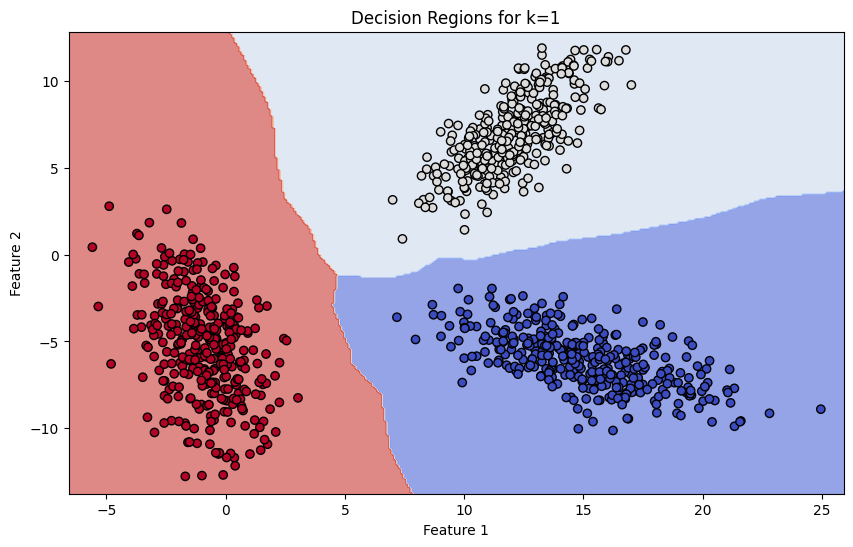

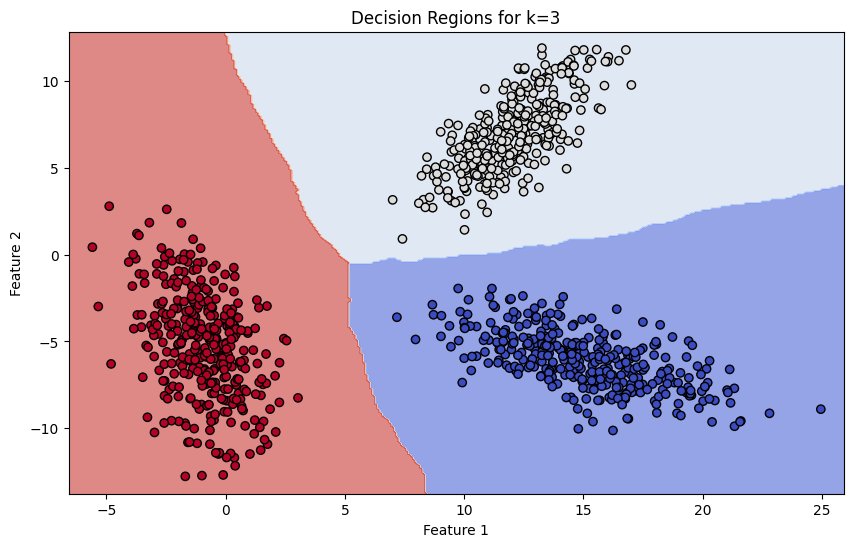

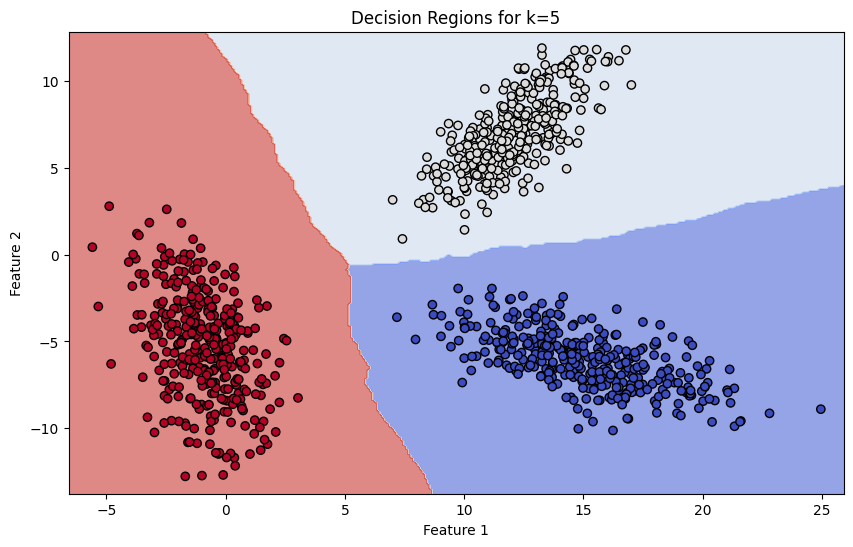

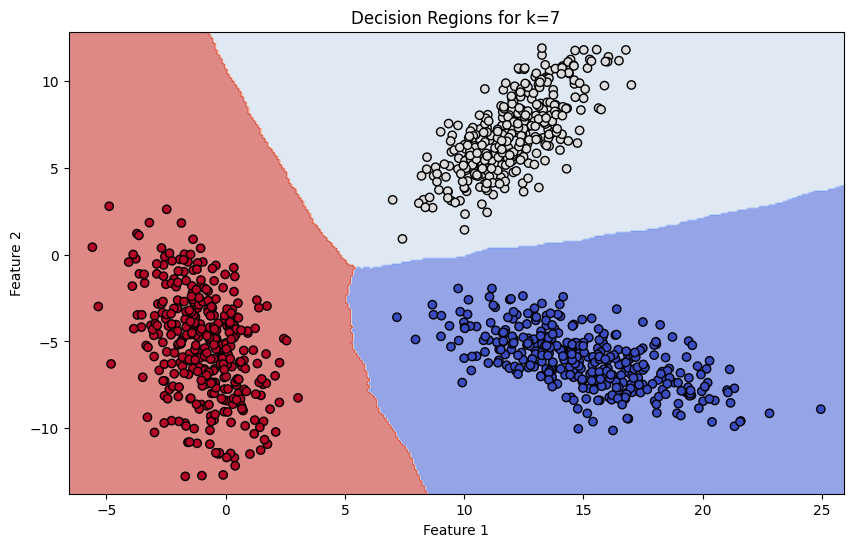

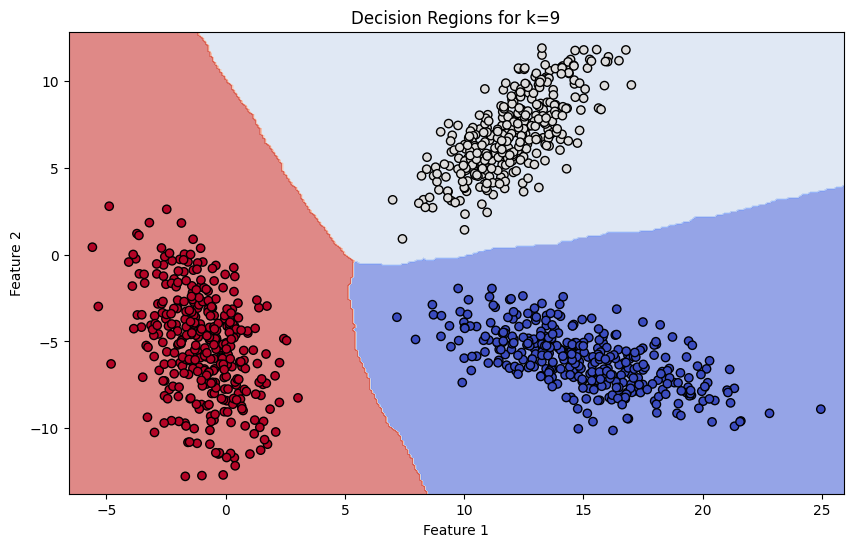

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report
import math  # For gamma function

def knn_density_estimation(train_data, test_point, k):
    """
    Estimate density at test_point using k-nearest neighbors in train_data.
    """
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(train_data)
    distances, _ = nn.kneighbors([test_point])
    radius = distances[0][-1]
    volume = (np.pi ** (train_data.shape[1] / 2)) * (radius ** train_data.shape[1]) / math.gamma(train_data.shape[1] / 2 + 1)
    return k / (len(train_data) * volume)

def bayes_classifier_knn(train_data_list, test_data_list, k_values):
    """
    Classify test data using Bayes classifier with KNN density estimation.
    """
    priors = [len(train_data) / sum(len(df) for df in train_data_list) for train_data in train_data_list]
    results = {}

    for k in k_values:
        predictions = []
        true_labels = []

        for test_class_idx, test_data in enumerate(test_data_list):
            true_labels.extend([test_class_idx] * len(test_data))
            for test_point in test_data:
                posteriors = []
                for class_idx, train_data in enumerate(train_data_list):
                    likelihood = knn_density_estimation(train_data, test_point, k)
                    posteriors.append(likelihood * priors[class_idx])
                predictions.append(np.argmax(posteriors))

        # Generate classification report
        true_labels = np.array(true_labels)
        predictions = np.array(predictions)
        report = classification_report(true_labels, predictions, target_names=[f"Class {i}" for i in range(len(train_data_list))])
        results[k] = {
            'report': report,
            'true_labels': true_labels,
            'predictions': predictions
        }
        print(f"Classification Report for k={k}:\n{report}")

    return results

def plot_decision_regions(train_data_list, results, k, feature_indices=(0, 1)):
    """
    Plot decision regions for a given k.
    """
    train_data_combined = np.vstack(train_data_list)
    labels_combined = np.concatenate([[i] * len(df) for i, df in enumerate(train_data_list)])

    x_min, x_max = train_data_combined[:, feature_indices[0]].min() - 1, train_data_combined[:, feature_indices[0]].max() + 1
    y_min, y_max = train_data_combined[:, feature_indices[1]].min() - 1, train_data_combined[:, feature_indices[1]].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    priors = [len(train_data) / sum(len(df) for df in train_data_list) for train_data in train_data_list]

    predictions = []
    for point in mesh_points:
        posteriors = []
        for class_idx, train_data in enumerate(train_data_list):
            likelihood = knn_density_estimation(train_data, point, k)
            posteriors.append(likelihood * priors[class_idx])
        predictions.append(np.argmax(posteriors))

    predictions = np.array(predictions).reshape(xx.shape)
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, predictions, alpha=0.6, cmap=plt.cm.coolwarm)
    plt.scatter(train_data_combined[:, feature_indices[0]], train_data_combined[:, feature_indices[1]],
                c=labels_combined, edgecolor='k', cmap=plt.cm.coolwarm)
    plt.title(f"Decision Regions for k={k}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

train_data_list = [df1_train.to_numpy(), df2_train.to_numpy(), df3_train.to_numpy()]
test_data_list = [df1_test.to_numpy(), df2_test.to_numpy(), df3_test.to_numpy()]

k_values = [1, 3, 5, 7, 9]
results = bayes_classifier_knn(train_data_list, test_data_list, k_values)

# Plot decision regions for each k
for k in k_values:
    plot_decision_regions(train_data_list, results, k)


## FDA

In [ ]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report
from collections import Counter

def fda_one_vs_one(train_data_list, test_data_list, num_components=1, gmm_components=None):
    """
    Apply FDA pairwise, train Bayes classifiers, and classify using one-vs-one voting.
    Supports both unimodal and multimodal Gaussian models.
    """
    num_classes = len(train_data_list)
    class_pairs = [(i, j) for i in range(num_classes) for j in range(i + 1, num_classes)]
    pairwise_classifiers = {}

    # Train pairwise classifiers
    for class_1, class_2 in class_pairs:
        print(f"Training pair: Class {class_1} vs Class {class_2}")

        # Combine data for the two classes
        data_1, data_2 = train_data_list[class_1], train_data_list[class_2]
        labels = np.array([0] * len(data_1) + [1] * len(data_2))
        combined_data = np.vstack([data_1, data_2])

        # Apply FDA
        lda = LDA(n_components=num_components)
        reduced_data = lda.fit_transform(combined_data, labels)

        if gmm_components is None:
            # Unimodal Gaussian model
            mean_1 = np.mean(reduced_data[labels == 0], axis=0)
            cov_1 = np.cov(reduced_data[labels == 0], rowvar=False)
            mean_2 = np.mean(reduced_data[labels == 1], axis=0)
            cov_2 = np.cov(reduced_data[labels == 1], rowvar=False)

            # Ensure covariance matrices are 2D
            cov_1 = np.atleast_2d(cov_1)
            cov_2 = np.atleast_2d(cov_2)

            model = {
                "lda": lda,
                "mean_1": mean_1,
                "cov_1": cov_1,
                "mean_2": mean_2,
                "cov_2": cov_2
            }
        else:
            # Multimodal Gaussian model using GMM
            gmm_1 = GaussianMixture(n_components=gmm_components, random_state=42).fit(reduced_data[labels == 0])
            gmm_2 = GaussianMixture(n_components=gmm_components, random_state=42).fit(reduced_data[labels == 1])
            model = {
                "lda": lda,
                "gmm_1": gmm_1,
                "gmm_2": gmm_2
            }

        # Save the model
        pairwise_classifiers[(class_1, class_2)] = model

    # Classify test data
    predictions = []
    true_labels = []
    for class_idx, test_data in enumerate(test_data_list):
        for point in test_data:
            votes = []
            for (class_1, class_2), clf in pairwise_classifiers.items():
                lda = clf["lda"]
                reduced_point = lda.transform([point])

                if gmm_components is None:
                    # Unimodal Gaussian classification
                    mean_1, cov_1 = clf["mean_1"], clf["cov_1"]
                    mean_2, cov_2 = clf["mean_2"], clf["cov_2"]

                    diff_1 = reduced_point - mean_1
                    log_det_1 = np.log(np.linalg.det(cov_1))
                    prob_1 = np.exp(-0.5 * diff_1 @ np.linalg.inv(cov_1) @ diff_1.T) / \
                             np.sqrt((2 * np.pi) ** len(reduced_point) * np.linalg.det(cov_1))

                    diff_2 = reduced_point - mean_2
                    log_det_2 = np.log(np.linalg.det(cov_2))
                    prob_2 = np.exp(-0.5 * diff_2 @ np.linalg.inv(cov_2) @ diff_2.T) / \
                             np.sqrt((2 * np.pi) ** len(reduced_point) * np.linalg.det(cov_2))
                else:
                    # Multimodal Gaussian classification using GMM
                    prob_1 = np.exp(clf["gmm_1"].score_samples(reduced_point))[0]
                    prob_2 = np.exp(clf["gmm_2"].score_samples(reduced_point))[0]

                # Vote for the class with higher probability
                votes.append(class_1 if prob_1 > prob_2 else class_2)

            # Majority voting
            predicted_class = Counter(votes).most_common(1)[0][0]
            predictions.append(predicted_class)
            true_labels.append(class_idx)

    # Classification Report
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)
    model_type = "Unimodal Gaussian" if gmm_components is None else f"GMM ({gmm_components} components)"
    print(f"One-vs-One FDA + {model_type} Classifier Report:")
    print(classification_report(true_labels, predictions))
    return predictions

# Example Workflow
train_data_list = [df1_train.to_numpy(), df2_train.to_numpy(), df3_train.to_numpy()]
test_data_list = [df1_test.to_numpy(), df2_test.to_numpy(), df3_test.to_numpy()]

# Unimodal Gaussian
predictions_unimodal = fda_one_vs_one(train_data_list, test_data_list, num_components=1, gmm_components=None)

# Multimodal Gaussian (GMM)
predictions_multimodal_2 = fda_one_vs_one(train_data_list, test_data_list, num_components=1, gmm_components=2)
predictions_multimodal_4 = fda_one_vs_one(train_data_list, test_data_list, num_components=1, gmm_components=4)


Training pair: Class 0 vs Class 1
Training pair: Class 0 vs Class 2
Training pair: Class 1 vs Class 2
One-vs-One FDA + Unimodal Gaussian Classifier Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       150
           1       1.00      1.00      1.00       150
           2       1.00      1.00      1.00       150

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450

Training pair: Class 0 vs Class 1
Training pair: Class 0 vs Class 2
Training pair: Class 1 vs Class 2
One-vs-One FDA + GMM (2 components) Classifier Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       150
           1       1.00      1.00      1.00       150
           2       1.00      1.00      1.00       150

    accuracy                           1.00       450
   macro avg       1.00      1.00 

Processing pair: Class 0 vs Class 1


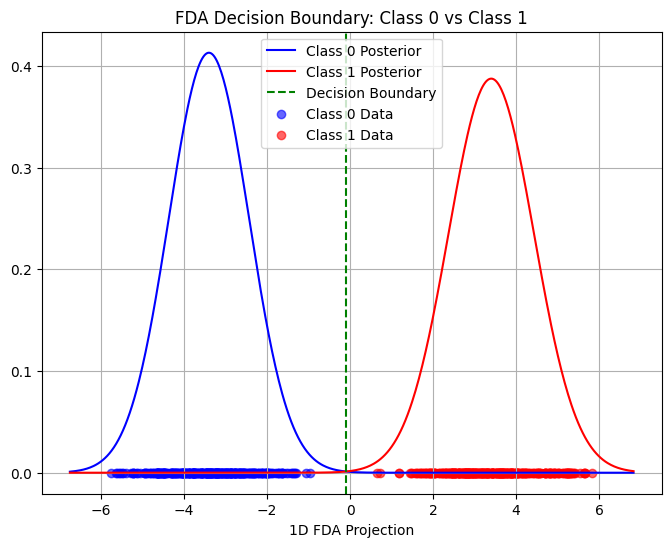

Processing pair: Class 0 vs Class 2


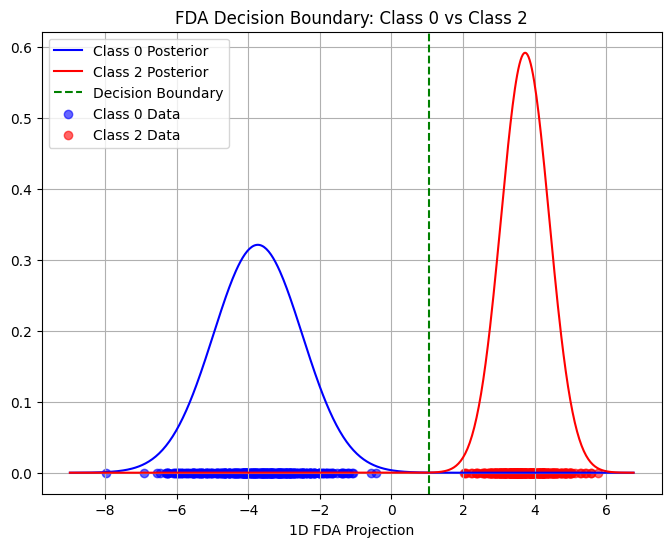

Processing pair: Class 1 vs Class 2


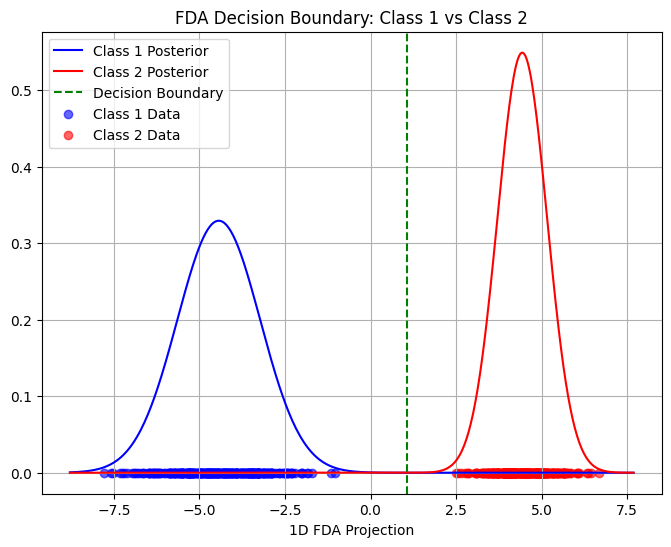

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.mixture import GaussianMixture

def plot_decision_boundary_fda_pairwise(train_data_list, k=1):
    """
    Visualize the decision boundary for each pair of classes using FDA and Bayes classifier.
    """
    class_pairs = [(0, 1), (0, 2), (1, 2)]
    for pair in class_pairs:
        class_1, class_2 = pair
        print(f"Processing pair: Class {class_1} vs Class {class_2}")

        # Combine data for the two classes
        data_pair = np.vstack([train_data_list[class_1], train_data_list[class_2]])
        labels_pair = np.hstack([np.zeros(len(train_data_list[class_1])),
                                 np.ones(len(train_data_list[class_2]))])

        # Apply FDA to reduce to 1D
        lda = LDA(n_components=1)
        data_pair_lda = lda.fit_transform(data_pair, labels_pair)

        # Train GMM for each class
        gmm_1 = GaussianMixture(n_components=k, random_state=42).fit(data_pair_lda[labels_pair == 0])
        gmm_2 = GaussianMixture(n_components=k, random_state=42).fit(data_pair_lda[labels_pair == 1])

        # Generate grid points in 1D space
        x_min, x_max = data_pair_lda.min() - 1, data_pair_lda.max() + 1
        x = np.linspace(x_min, x_max, 500).reshape(-1, 1)

        # Compute posteriors for each grid point
        log_prob_1 = gmm_1.score_samples(x)
        log_prob_2 = gmm_2.score_samples(x)
        posteriors_1 = np.exp(log_prob_1)
        posteriors_2 = np.exp(log_prob_2)

        # Decision boundary: Where posteriors are equal
        decision_boundary = x[np.abs(posteriors_1 - posteriors_2).argmin()]

        # Plot
        plt.figure(figsize=(8, 6))
        plt.plot(x, posteriors_1, label=f"Class {class_1} Posterior", color="blue")
        plt.plot(x, posteriors_2, label=f"Class {class_2} Posterior", color="red")
        plt.axvline(decision_boundary, color="green", linestyle="--", label="Decision Boundary")

        # Scatter plot of 1D-reduced data points
        plt.scatter(data_pair_lda[labels_pair == 0], np.zeros_like(data_pair_lda[labels_pair == 0]),
                    color="blue", label=f"Class {class_1} Data", alpha=0.6)
        plt.scatter(data_pair_lda[labels_pair == 1], np.zeros_like(data_pair_lda[labels_pair == 1]),
                    color="red", label=f"Class {class_2} Data", alpha=0.6)

        plt.title(f"FDA Decision Boundary: Class {class_1} vs Class {class_2}")
        plt.xlabel("1D FDA Projection")
        plt.legend()
        plt.grid(True)
        plt.show()

# Example usage
plot_decision_boundary_fda_pairwise(train_data_list, k=1)


## Perceptron

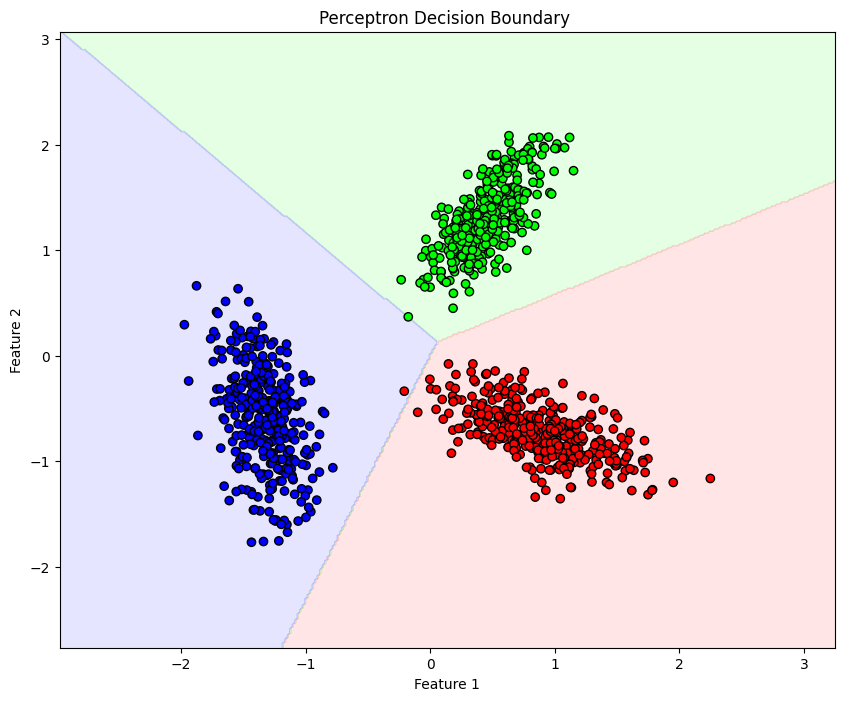


Classification Report for max_iter=2000:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       150
         1.0       1.00      1.00      1.00       150
         2.0       0.98      1.00      0.99       150

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450

Number of iterations until convergence: 7

Final Results:

Max Iterations = 2000:
Training Accuracy: 0.9990
Test Accuracy: 0.9933


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, classification_report
from matplotlib.colors import ListedColormap

def prepare_data(df1_train, df1_test, df2_train, df2_test, df3_train, df3_test):
    """
    Prepare and scale the data for the perceptron classifier
    """
    # Combine training data
    X_train = np.vstack([df1_train, df2_train, df3_train])
    y_train = np.hstack([np.zeros(len(df1_train)),
                        np.ones(len(df2_train)),
                        2*np.ones(len(df3_train))])

    # Combine test data
    X_test = np.vstack([df1_test, df2_test, df3_test])
    y_test = np.hstack([np.zeros(len(df1_test)),
                       np.ones(len(df2_test)),
                       2*np.ones(len(df3_test))])

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

def plot_decision_boundary(X, y, model, title):
    """
    Plot the decision boundary and data points
    """
    h = 0.02  # Step size in the mesh

    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    # Plot the decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict for each point in the mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.3)
    # Fixed: Changed edcolor to edgecolor
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

def evaluate_perceptron(X_train, X_test, y_train, y_test, max_iters=[2000]):
    """
    Evaluate perceptron with different maximum iterations
    """
    results = {}

    for n_iter in max_iters:
        # Initialize and train perceptron with increased iterations and adjusted learning rate
        perceptron = Perceptron(max_iter=n_iter,
                               random_state=42,
                               eta0=0.1,  # Reduced learning rate
                               early_stopping=True,  # Enable early stopping
                               validation_fraction=0.1,  # Use 10% of training data for validation
                               n_iter_no_change=5,  # Number of iterations with no improvement
                               shuffle=True)  # Shuffle training data

        perceptron.fit(X_train, y_train)

        # Make predictions
        y_pred_train = perceptron.predict(X_train)
        y_pred_test = perceptron.predict(X_test)

        # Calculate accuracies
        train_accuracy = accuracy_score(y_train, y_pred_train)
        test_accuracy = accuracy_score(y_test, y_pred_test)

        results[n_iter] = {
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'model': perceptron
        }

        # Plot decision boundary
        plot_decision_boundary(X_train, y_train, perceptron,
                             f'Perceptron Decision Boundary ')

        # Print classification report
        print(f'\nClassification Report for max_iter={n_iter}:')
        print(classification_report(y_test, y_pred_test))

        # Print convergence information
        print(f'Number of iterations until convergence: {perceptron.n_iter_}')

    return results

# Prepare the data
X_train, X_test, y_train, y_test = prepare_data(
    df1_train, df1_test, df2_train, df2_test, df3_train, df3_test
)

# Define maximum iterations to test with increased values
max_iters = [2000]

# Run experiments
results = evaluate_perceptron(X_train, X_test, y_train, y_test, max_iters)

# Print final results
print("\nFinal Results:")
for n_iter, metrics in results.items():
    print(f'\nMax Iterations = {n_iter}:')
    print(f'Training Accuracy: {metrics["train_accuracy"]:.4f}')
    print(f'Test Accuracy: {metrics["test_accuracy"]:.4f}')


## Logistic Regression

In [ ]:
train_data = pd.concat([df1_train, df2_train, df3_train])
test_data = pd.concat([df1_test, df2_test, df3_test])

# Assign class labels (assume class labels as 0, 1, 2 for simplicity)
train_labels = ([0] * len(df1_train)) + ([1] * len(df2_train)) + ([2] * len(df3_train))
test_labels = ([0] * len(df1_test)) + ([1] * len(df2_test)) + ([2] * len(df3_test))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


def calculate_metrics(y_true, y_pred, classes=[0, 1, 2]):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None, labels=classes)
    recall = recall_score(y_true, y_pred, average=None, labels=classes)
    f_measure = f1_score(y_true, y_pred, average=None, labels=classes)

    mean_precision = np.mean(precision)
    mean_recall = np.mean(recall)
    mean_f_measure = np.mean(f_measure)

    return accuracy, precision, recall, f_measure, mean_precision, mean_recall, mean_f_measure

Results for Logistic Regression Classifier:
Accuracy: 1.0
Precision: [1. 1. 1.]
Mean Precision: 1.0
Recall: [1. 1. 1.]
Mean Recall: 1.0
F-measure: [1. 1. 1.]
Mean F-measure: 1.0
Confusion Matrix:
[[150   0   0]
 [  0 150   0]
 [  0   0 150]]



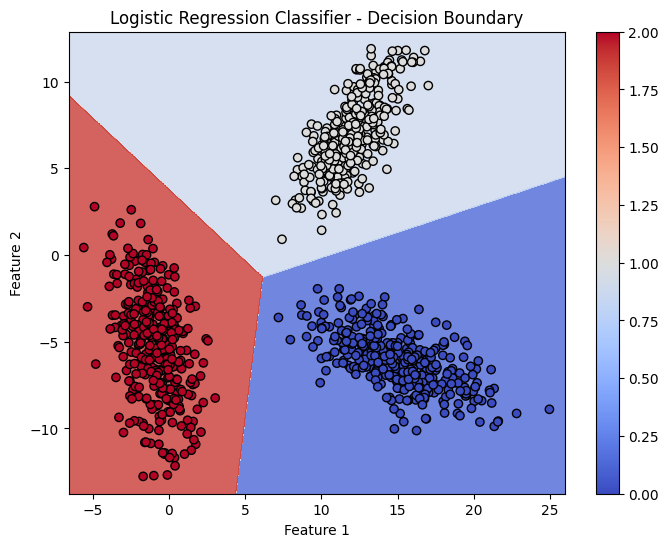

In [ ]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


def prepare_data(df1_train, df1_test, df2_train, df2_test, df3_train, df3_test):
    """
    Prepare and scale the data for the perceptron classifier
    """
    # Combine training data
    X_train = np.vstack([df1_train, df2_train, df3_train])
    y_train = np.hstack([np.zeros(len(df1_train)),
                        np.ones(len(df2_train)),
                        2*np.ones(len(df3_train))])

    # Combine test data
    X_test = np.vstack([df1_test, df2_test, df3_test])
    y_test = np.hstack([np.zeros(len(df1_test)),
                       np.ones(len(df2_test)),
                       2*np.ones(len(df3_test))])

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test


X_train, X_test, y_train, y_test = prepare_data(
    df1_train, df1_test, df2_train, df2_test, df3_train, df3_test
)

# Train the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(train_data, train_labels)  # Replace train_fda with train_data

# Predict on test data
y_pred_log_reg = log_reg.predict(test_data)  # Replace test_fda with test_data

# Calculate metrics for the Logistic Regression classifier
accuracy_log_reg, precision_log_reg, recall_log_reg, f_measure_log_reg, mean_precision_log_reg, mean_recall_log_reg, mean_f_measure_log_reg = calculate_metrics(
    test_labels, y_pred_log_reg)

# Print classification results for Logistic Regression
print("Results for Logistic Regression Classifier:")
print(f"Accuracy: {accuracy_log_reg}")
print(f"Precision: {precision_log_reg}")
print(f"Mean Precision: {mean_precision_log_reg}")
print(f"Recall: {recall_log_reg}")
print(f"Mean Recall: {mean_recall_log_reg}")
print(f"F-measure: {f_measure_log_reg}")
print(f"Mean F-measure: {mean_f_measure_log_reg}")
print(f"Confusion Matrix:\n{confusion_matrix(test_labels, y_pred_log_reg)}\n")

# Plot decision boundary for Logistic Regression classifier (using raw feature data)
def plot_decision_boundary(X, y, model, title):
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Create meshgrid for plotting
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap='coolwarm')
    plt.title(f"{title} - Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.colorbar()
    plt.show()

# Assuming train_data has at least two features for visualization
plot_decision_boundary(train_data.values, train_labels, log_reg, "Logistic Regression Classifier")

## SVM


--------------------------------------------------
Kernel: linear, Parameters: C=0.1
--------------------------------------------------
Overall Accuracy: 1.0000

Per-class Metrics:

Class 0:
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Class 1:
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Class 2:
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Mean Metrics:
Mean Precision: 1.0000
Mean Recall: 1.0000
Mean F1-score: 1.0000

Confusion Matrix:
[[150   0   0]
 [  0 150   0]
 [  0   0 150]]

--------------------------------------------------
Kernel: linear, Parameters: C=1.0
--------------------------------------------------
Overall Accuracy: 1.0000

Per-class Metrics:

Class 0:
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Class 1:
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Class 2:
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Mean Metrics:
Mean Precision: 1.0000
Mean Recall: 1.0000
Mean F1-score: 1.0000

Confusion Matrix:
[[150   0   0]
 [  0 150   0]
 [

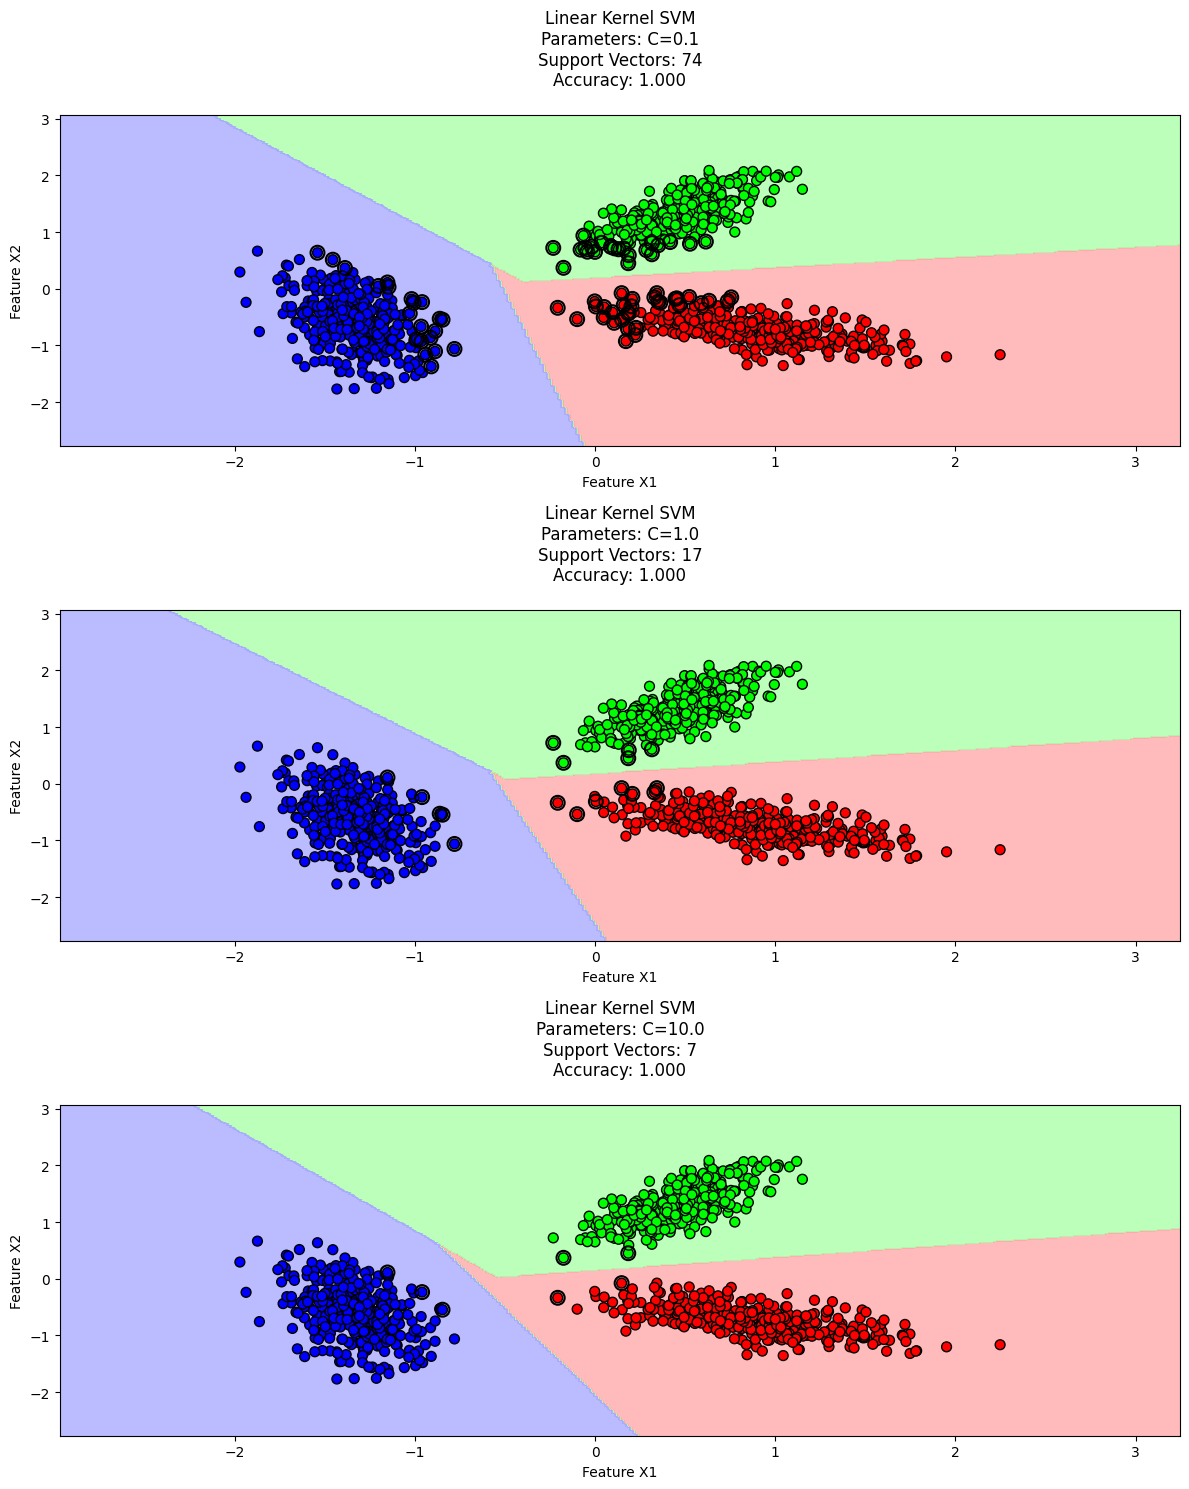

Best SVM for linear kernel:
Parameters: {'C': 10.0}
Accuracy: 1.0000

--------------------------------------------------
Kernel: poly, Parameters: C=0.1, degree=2, coef0=0
--------------------------------------------------
Overall Accuracy: 0.9644

Per-class Metrics:

Class 0:
Precision: 0.9250
Recall: 0.9867
F1-score: 0.9548

Class 1:
Precision: 0.9929
Recall: 0.9333
F1-score: 0.9622

Class 2:
Precision: 0.9799
Recall: 0.9733
F1-score: 0.9766

Mean Metrics:
Mean Precision: 0.9659
Mean Recall: 0.9644
Mean F1-score: 0.9645

Confusion Matrix:
[[148   0   2]
 [  9 140   1]
 [  3   1 146]]

--------------------------------------------------
Kernel: poly, Parameters: C=0.1, degree=3, coef0=0
--------------------------------------------------
Overall Accuracy: 0.9689

Per-class Metrics:

Class 0:
Precision: 0.9146
Recall: 1.0000
F1-score: 0.9554

Class 1:
Precision: 1.0000
Recall: 0.9067
F1-score: 0.9510

Class 2:
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Mean Metrics:
Mean Precisio

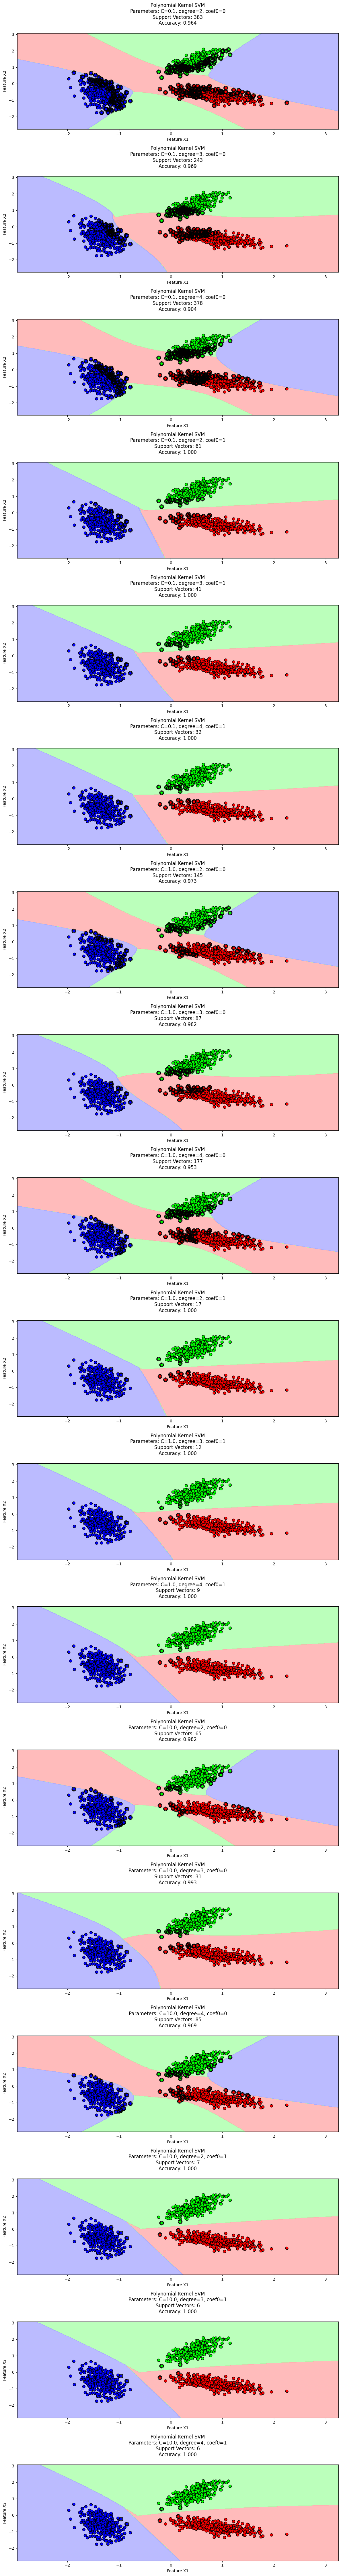

Best SVM for poly kernel:
Parameters: {'C': 10.0, 'degree': 4, 'coef0': 1}
Accuracy: 1.0000

--------------------------------------------------
Kernel: rbf, Parameters: C=0.1, gamma=0.1
--------------------------------------------------
Overall Accuracy: 1.0000

Per-class Metrics:

Class 0:
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Class 1:
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Class 2:
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Mean Metrics:
Mean Precision: 1.0000
Mean Recall: 1.0000
Mean F1-score: 1.0000

Confusion Matrix:
[[150   0   0]
 [  0 150   0]
 [  0   0 150]]

--------------------------------------------------
Kernel: rbf, Parameters: C=1.0, gamma=0.1
--------------------------------------------------
Overall Accuracy: 1.0000

Per-class Metrics:

Class 0:
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Class 1:
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Class 2:
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Mean Metrics:
Mean Pre

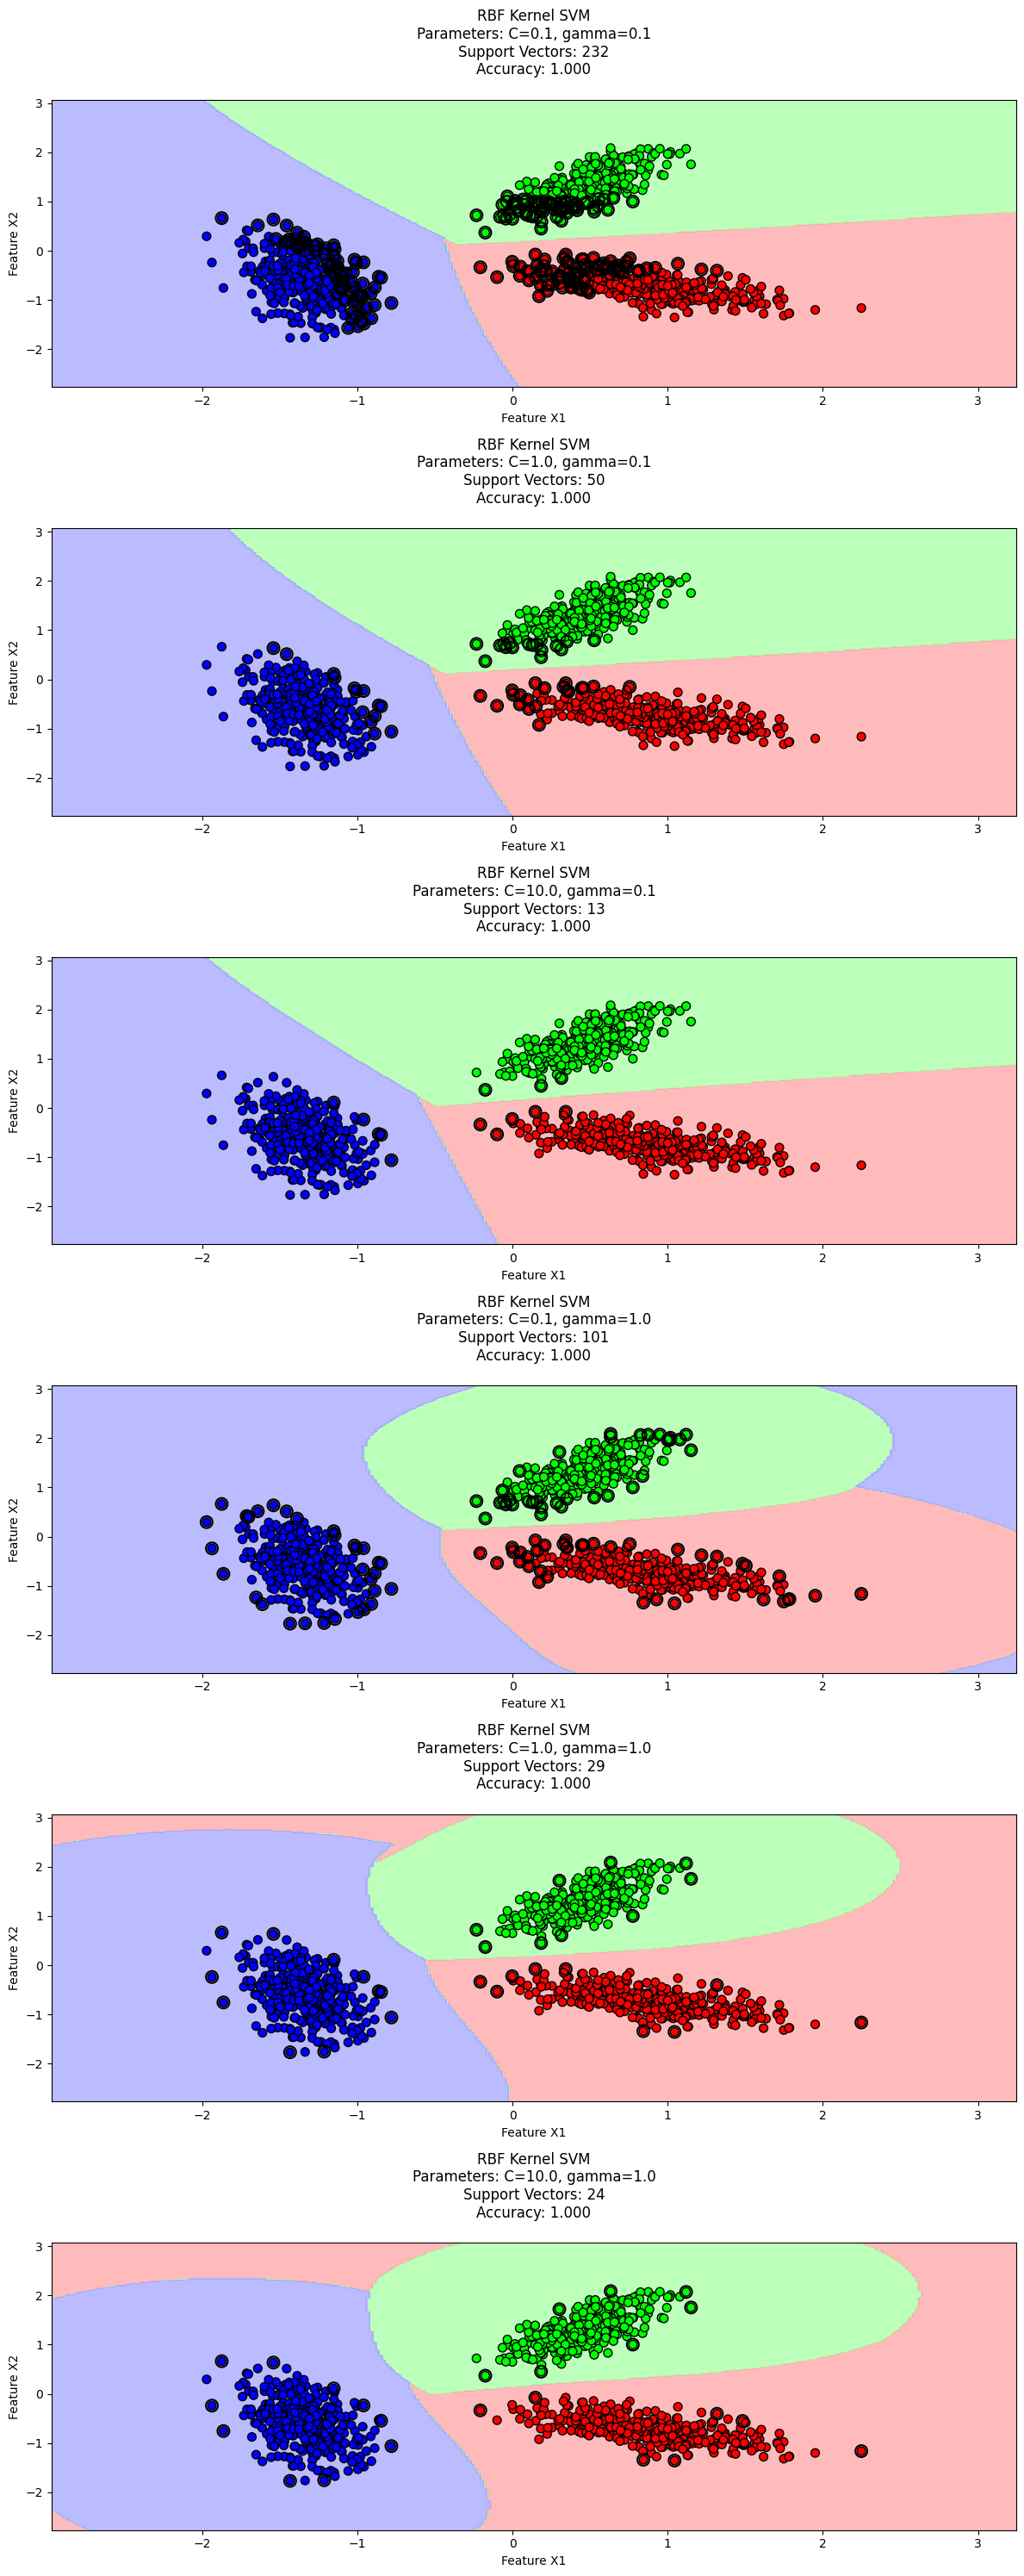

Best SVM for rbf kernel:
Parameters: {'C': 10.0, 'gamma': 1.0}
Accuracy: 1.0000


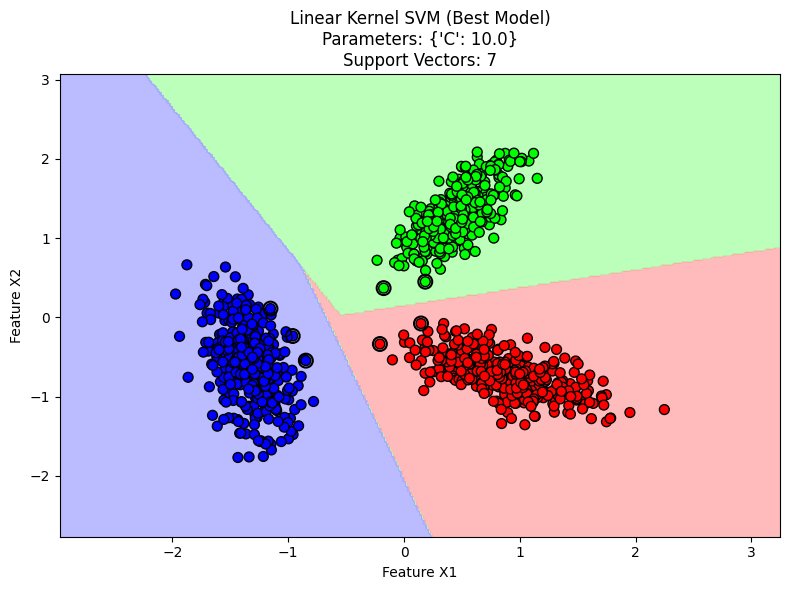

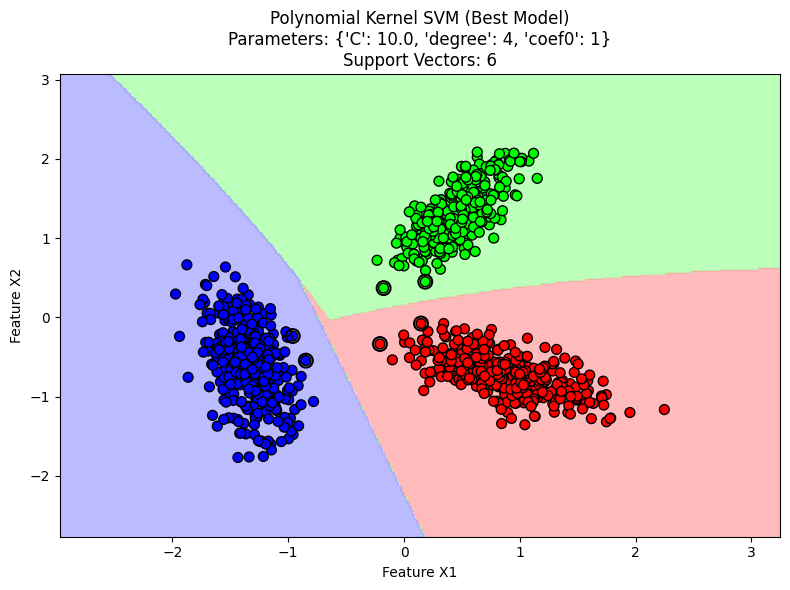

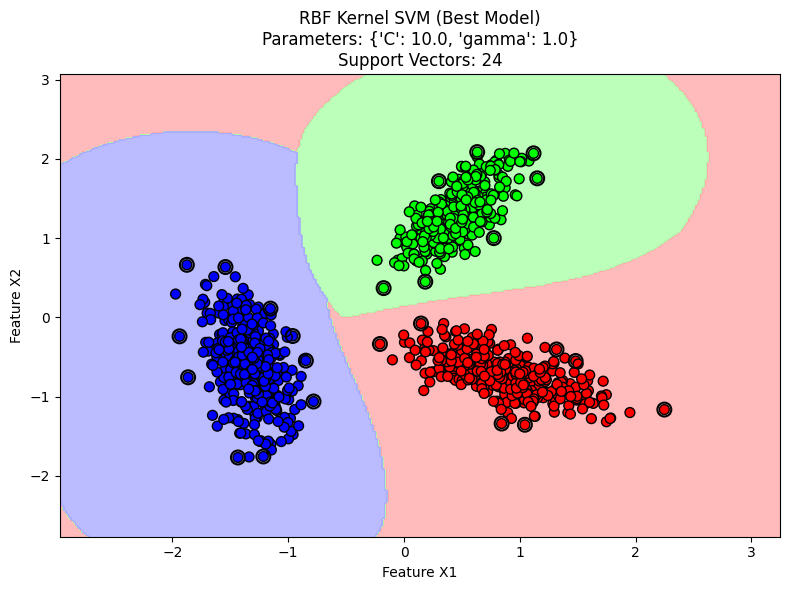

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, classification_report
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC


def plot_decision_regions_with_metrics(X, y, kernel, params_list, title_prefix, X_test, y_test):
    """
    Plot decision regions and calculate detailed metrics for each parameter combination.
    Returns the best SVM based on accuracy.
    """
    fig, axes = plt.subplots(len(params_list), 1, figsize=(12, 5 * len(params_list)))
    if len(params_list) == 1:
        axes = [axes]

    # Set up the mesh grid
    h = 0.02
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                           np.arange(x2_min, x2_max, h))

    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    best_model = None
    best_accuracy = 0
    best_params = None

    for idx, params in enumerate(params_list):
        # Create and train SVM
        svm = SVC(kernel=kernel, **params, random_state=42)
        svm.fit(X, y)

        # Make predictions on mesh grid
        Z = svm.predict(np.c_[xx1.ravel(), xx2.ravel()])
        Z = Z.reshape(xx1.shape)

        # Plot decision regions
        axes[idx].contourf(xx1, xx2, Z, cmap=cmap_light, alpha=0.8)
        axes[idx].scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='black', s=50)
        axes[idx].scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1],
                          s=100, facecolors='none', edgecolor='black', linewidth=1.5)

        # Calculate metrics on test data
        y_pred = svm.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        #accuracy = accuracy_score(y_test, y_pred)
        precision_per_class = precision_score(y_test, y_pred, average=None)
        recall_per_class = recall_score(y_test, y_pred, average=None)
        f1_per_class = f1_score(y_test, y_pred, average=None)
        conf_matrix = confusion_matrix(y_test, y_pred)

        # Create parameter string for title
        param_str = ', '.join([f'{k}={v}' for k, v in params.items()])
        metrics_str = f'Accuracy: {accuracy:.3f}\n'

        # Add metrics to plot title
        axes[idx].set_title(
            f'{title_prefix}\nParameters: {param_str}\n'
            f'Support Vectors: {len(svm.support_vectors_)}\n{metrics_str}'
        )
        axes[idx].set_xlabel('Feature X1')
        axes[idx].set_ylabel('Feature X2')

        # Print detailed metrics
        print(f"\n{'-'*50}")
        print(f"Kernel: {kernel}, Parameters: {param_str}")
        print(f"{'-'*50}")
        print(f"Overall Accuracy: {accuracy:.4f}")
        print("\nPer-class Metrics:")
        for i in range(len(precision_per_class)):
            print(f"\nClass {i}:")
            print(f"Precision: {precision_per_class[i]:.4f}")
            print(f"Recall: {recall_per_class[i]:.4f}")
            print(f"F1-score: {f1_per_class[i]:.4f}")

        print("\nMean Metrics:")
        print(f"Mean Precision: {np.mean(precision_per_class):.4f}")
        print(f"Mean Recall: {np.mean(recall_per_class):.4f}")
        print(f"Mean F1-score: {np.mean(f1_per_class):.4f}")

        print("\nConfusion Matrix:")
        print(conf_matrix)

        if accuracy >= best_accuracy:
            best_accuracy = accuracy
            best_model = svm
            best_params = params

        # Create parameter string for title
        param_str = ', '.join([f'{k}={v}' for k, v in params.items()])
        metrics_str = f'Accuracy: {accuracy:.3f}\n'

        # Add metrics to plot title
        axes[idx].set_title(
            f'{title_prefix}\nParameters: {param_str}\n'
            f'Support Vectors: {len(svm.support_vectors_)}\n{metrics_str}'
        )
        axes[idx].set_xlabel('Feature X1')
        axes[idx].set_ylabel('Feature X2')

    plt.tight_layout()
    plt.show()

    print(f"Best SVM for {kernel} kernel:")
    print(f"Parameters: {best_params}")
    print(f"Accuracy: {best_accuracy:.4f}")
    return best_model, best_params


def plot_best_svm(X, y, X_test, y_test, model, params, kernel, title_prefix):
    """
    Plot decision regions for the best SVM model.
    """
    h = 0.02
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                           np.arange(x2_min, x2_max, h))

    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Z = Z.reshape(xx1.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx1, xx2, Z, cmap=cmap_light, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='black', s=50)
    plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                s=100, facecolors='none', edgecolor='black', linewidth=1.5)
    plt.title(
        f'{title_prefix} (Best Model)\nParameters: {params}\n'
        f'Support Vectors: {len(model.support_vectors_)}'
    )
    plt.xlabel('Feature X1')
    plt.ylabel('Feature X2')
    plt.tight_layout()
    plt.show()


def main():
    # Prepare and scale data
    X = pd.concat([df1_train, df2_train, df3_train], axis=0).values
    y = np.array([0] * len(df1_train) + [1] * len(df2_train) + [2] * len(df3_train))

    X_test = pd.concat([df1_test, df2_test, df3_test], axis=0).values
    y_test = np.array([0] * len(df1_test) + [1] * len(df2_test) + [2] * len(df3_test))

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_test_scaled = scaler.transform(X_test)

    # Linear Kernel
    linear_params = [{'C': 0.1}, {'C': 1.0}, {'C': 10.0}]
    best_linear_model, best_linear_params = plot_decision_regions_with_metrics(
        X_scaled, y, 'linear', linear_params, 'Linear Kernel SVM', X_test_scaled, y_test)

    # Polynomial Kernel
    poly_params = [{'C': 0.1, 'degree': 2, 'coef0': 0},
        {'C': 0.1, 'degree': 3, 'coef0': 0},
        {'C': 0.1, 'degree': 4, 'coef0': 0},
        {'C': 0.1, 'degree': 2, 'coef0': 1},
        {'C': 0.1, 'degree': 3, 'coef0': 1},
        {'C': 0.1, 'degree': 4, 'coef0': 1},
        {'C': 1.0, 'degree': 2, 'coef0': 0},
        {'C': 1.0, 'degree': 3, 'coef0': 0},
        {'C': 1.0, 'degree': 4, 'coef0': 0},
        {'C': 1.0, 'degree': 2, 'coef0': 1},
        {'C': 1.0, 'degree': 3, 'coef0': 1},
        {'C': 1.0, 'degree': 4, 'coef0': 1},
        {'C': 10.0, 'degree': 2, 'coef0': 0},
        {'C': 10.0, 'degree': 3, 'coef0': 0},
        {'C': 10.0, 'degree': 4, 'coef0': 0},
        {'C': 10.0, 'degree': 2, 'coef0': 1},
        {'C': 10.0, 'degree': 3, 'coef0': 1},
        {'C': 10.0, 'degree': 4, 'coef0': 1}]
    best_poly_model, best_poly_params = plot_decision_regions_with_metrics(
        X_scaled, y, 'poly', poly_params, 'Polynomial Kernel SVM', X_test_scaled, y_test)

    # RBF Kernel
    rbf_params = [{'C': 0.1, 'gamma': 0.1},
        {'C': 1.0, 'gamma': 0.1},
        {'C': 10.0, 'gamma': 0.1},
        {'C': 0.1, 'gamma': 1.0},
        {'C': 1.0, 'gamma': 1.0},
        {'C': 10.0, 'gamma': 1.0}
    ]
    best_rbf_model, best_rbf_params = plot_decision_regions_with_metrics(
        X_scaled, y, 'rbf', rbf_params, 'RBF Kernel SVM', X_test_scaled, y_test)

    # Plot best models
    plot_best_svm(X_scaled, y, X_test_scaled, y_test, best_linear_model, best_linear_params, 'linear', 'Linear Kernel SVM')
    plot_best_svm(X_scaled, y, X_test_scaled, y_test, best_poly_model, best_poly_params, 'poly', 'Polynomial Kernel SVM')
    plot_best_svm(X_scaled, y, X_test_scaled, y_test, best_rbf_model, best_rbf_params, 'rbf', 'RBF Kernel SVM')


if __name__ == "__main__":
    main()
